In [ ]:
from pathlib import Path
import pandas as pd
from collections import Counter
# import seaborn as sns

In [ ]:
### test function 
import pandas as pd 

df = pd.read_csv('../data/mandragore_nh_global_kw_grouped.csv', sep=';')

In [ ]:
def export_mots_cles_groupes(input_csv):
    input_csv = Path(input_csv)
    output_csv = input_csv.with_name(input_csv.stem + "_kw_grouped.csv")

    df = pd.read_csv(input_csv, sep=";")

    # Agrège les mots-clés par (ms_folio, caption)
    df_keys = (
        df.groupby(["ms_folio", "caption"])["mot_cle"]
          .apply(lambda s: " | ".join(sorted(set(s.dropna().astype(str).str.strip()))))
          .reset_index(name="mots_cles")
    )

    # Remplace mot_cle par mots_cles (et garde toutes les autres colonnes du fichier initial)
    df_out = (
        df.drop(columns=["mot_cle"])
          .merge(df_keys, on=["ms_folio", "caption"], how="left")
    )

    df_out = df_out.drop_duplicates()
    df_out.to_csv(output_csv, index=False, sep=";")
    return df_out, output_csv

In [ ]:
def get_true_folios(df):
    df['vrai_folio'] = df.folio + '_' + df.manuscrit
    update_df = df
    return update_df

df = get_true_folios(df)

In [ ]:
df_save = df.copy()

In [ ]:
df_save.shape

(56286, 10)

In [ ]:
def merge_captions(df, kw_to_clean, kw_cleaned,  col ='caption') : 
    df[col] = df[col].apply(lambda x : kw_cleaned if kw_to_clean in str(x).lower() else x)
    return df 


def remove_captions(df, kw_to_remove, col ='caption') : 
    liste_keep = [i for i in df[col].tolist() if str(i).lower() not in kw_to_remove]
    df_new = df[df[col].isin(liste_keep)]
    
    return df_new


kw_to_remove = ["encadrement", "lettre ornée", "décor marginal", "lettre filigranée", "bout-de-ligne" , "bandeau"]
kw_to_cleaned = {
    'talisman' : 'Talisman',
    'astro' : 'Astronomie/Astrologie',
    'fable' : 'Fables',
    'flore' : 'Flore',
    'faune' : 'Faune',
}



for k, v in kw_to_cleaned.items() :
    df = merge_captions(df, k , v)

df = remove_captions(df, kw_to_remove)




In [ ]:
df.groupby('caption').size().reset_index(name='counts').sort_values(by='counts', ascending=False)

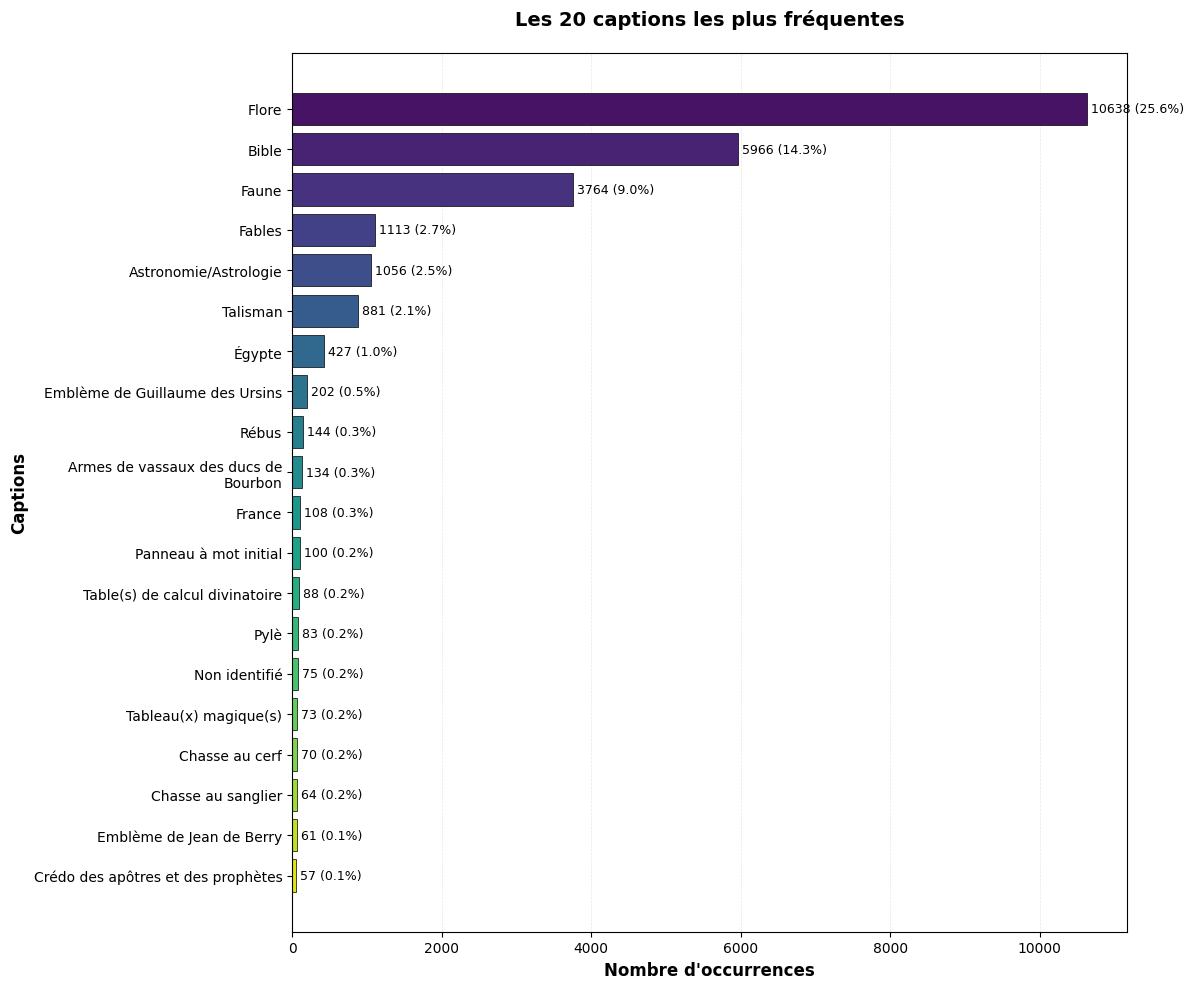

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import textwrap

def plot_top_captions(df, top_n=20, figsize=(12, 10), savepath=None, dpi=300):
    """
    Visualise les captions les plus fréquentes dans le dataframe.
    
    Parameters:
    -----------
    df : DataFrame
        DataFrame contenant la colonne 'caption'
    top_n : int
        Nombre de captions à afficher
    figsize : tuple
        Dimensions de la figure (largeur, hauteur)
    savepath : str, optional
        Chemin pour sauvegarder la figure (sans extension)
    dpi : int
        Résolution pour la sauvegarde
    """
    # Extraction des données
    top = Counter(df.caption.astype(str)).most_common(top_n)
    labels = [textwrap.fill(l.strip(), 35) for l, _ in top]
    counts = [c for _, c in top]
    
    # Création de la figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Palette de couleurs académique
    palette = sns.color_palette('viridis', n_colors=top_n)
    # Alternatives : 'mako_r', 'rocket_r', 'crest'
    
    # Création du barplot horizontal
    bars = ax.barh(
        labels, 
        counts, 
        color=palette,
        edgecolor='black',
        linewidth=0.5
    )
    
    # Amélioration du titre et des labels
    ax.set_title(
        f'Les {top_n} captions les plus fréquentes',
        fontsize=14,
        fontweight='bold',
        pad=20
    )
    ax.set_xlabel('Nombre d\'occurrences', fontsize=12, fontweight='bold')
    ax.set_ylabel('Captions', fontsize=12, fontweight='bold')
    
    # Ajout des valeurs sur les barres (nombre + pourcentage)
    total = len(df)
    for i, count in enumerate(counts):
        pct = count / total * 100
        ax.text(
            count, i, 
            f' {count} ({pct:.1f}%)', 
            va='center', 
            ha='left', 
            fontsize=9
        )
    
    # Amélioration de la lisibilité
    ax.tick_params(axis='both', labelsize=10)
    ax.invert_yaxis()  # Les plus fréquentes en haut
    
    # Grille légère pour faciliter la lecture
    ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    
    # Sauvegarde si demandée
    if savepath:
        plt.savefig(
            f'{savepath}.png', 
            dpi=dpi, 
            bbox_inches='tight', 
            facecolor='white', 
            edgecolor='none'
        )
    
    plt.show()
    
    return fig, ax


# Utilisation
fig, ax = plot_top_captions(
    df, 
    top_n=20, 
    figsize=(12, 10), 
    savepath='top_captions'
)

In [ ]:
from tqdm import tqdm
data= {
    'folio' : [] ,
    'kw' : []
}
for vf in tqdm(set(df['vrai_folio'].tolist())) : 
    
    data['folio'].append(vf)
    data['kw'].append(df[df.vrai_folio == vf ].mots_cles.tolist())



In [ ]:
# Tableau coocurences puis export 
df_cooc = pd.DataFrame(data)

In [ ]:
df_cooc = df_cooc.dropna(subset=['kw'])

def get_kw_as_string(kw_value):
    """
    Convertit une valeur de mots-clés en liste unique de chaînes nettoyées.
    
    Args:
        kw_value: Peut être une chaîne avec séparateur '|', une liste, ou autre
        
    Returns:
        Liste de mots-clés uniques sans doublons
    """
    result = []
    
    # Cas 1 : chaîne de caractères avec séparateur '|'
    if isinstance(kw_value, str):
        keywords = kw_value.split('|')
        result = [kw.strip() for kw in keywords]
    
    # Cas 2 : liste contenant des chaînes
    elif isinstance(kw_value, list):
        for item in kw_value:
            if isinstance(item, str):
                keywords = item.split('|')
                result.extend(kw.strip() for kw in keywords)
    
    # Cas 3 : autre type (None, int, etc.)
    # result reste une liste vide
    
    # Retourne une liste sans doublons
    return list(set(result))

df_cooc['kw'] = df_cooc['kw'].apply(get_kw_as_string)

In [ ]:
df_cooc['nbkw'] = df_cooc.kw.apply(lambda x : len(x))
df_cooc = df_cooc.sort_values(by='nbkw', ascending=False)

In [ ]:
df = pd.merge(
    df_cooc,
    df,
    on='vrai_folio',
    how='left'
).drop_duplicates(subset=['vrai_folio'])
df.drop(columns=['mots_cles'], inplace=True)

In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations

def ngrams_combinations(seq, n):
    """
    Génère tous les n-grams possibles à partir d'une séquence.
    
    Args:
        seq: Séquence (liste) de mots
        n: Taille du n-gram
        
    Returns:
        Liste de n-grams (chaînes jointes) ou None si la séquence est trop courte
    """
    return [" ".join(c) for c in combinations(seq, n)] if len(seq) >= n else None


def add_ngrams_columns(df, kw_column='kw', min_n=2, max_n=5):
    """
    Ajoute des colonnes de n-grams à un DataFrame.
    
    Args:
        df: DataFrame pandas contenant les données
        kw_column: Nom de la colonne contenant les listes de mots-clés (défaut: 'kw')
        min_n: Taille minimale des n-grams (défaut: 2)
        max_n: Taille maximale des n-grams (défaut: 5)
        
    Returns:
        DataFrame avec les nouvelles colonnes ngrams_2, ngrams_3, etc.
    """
    df_copy = df.copy()
    
    for i in range(min_n, max_n + 1):
        df_copy[f"ngrams_{i}"] = df_copy[kw_column].apply(
            lambda seq: ngrams_combinations(seq, i)
        )

    return df_copy

/var/folders/4m/_y65_yfx68b53909_pvhthr40000gn/T/ipykernel_6633/4043419706.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


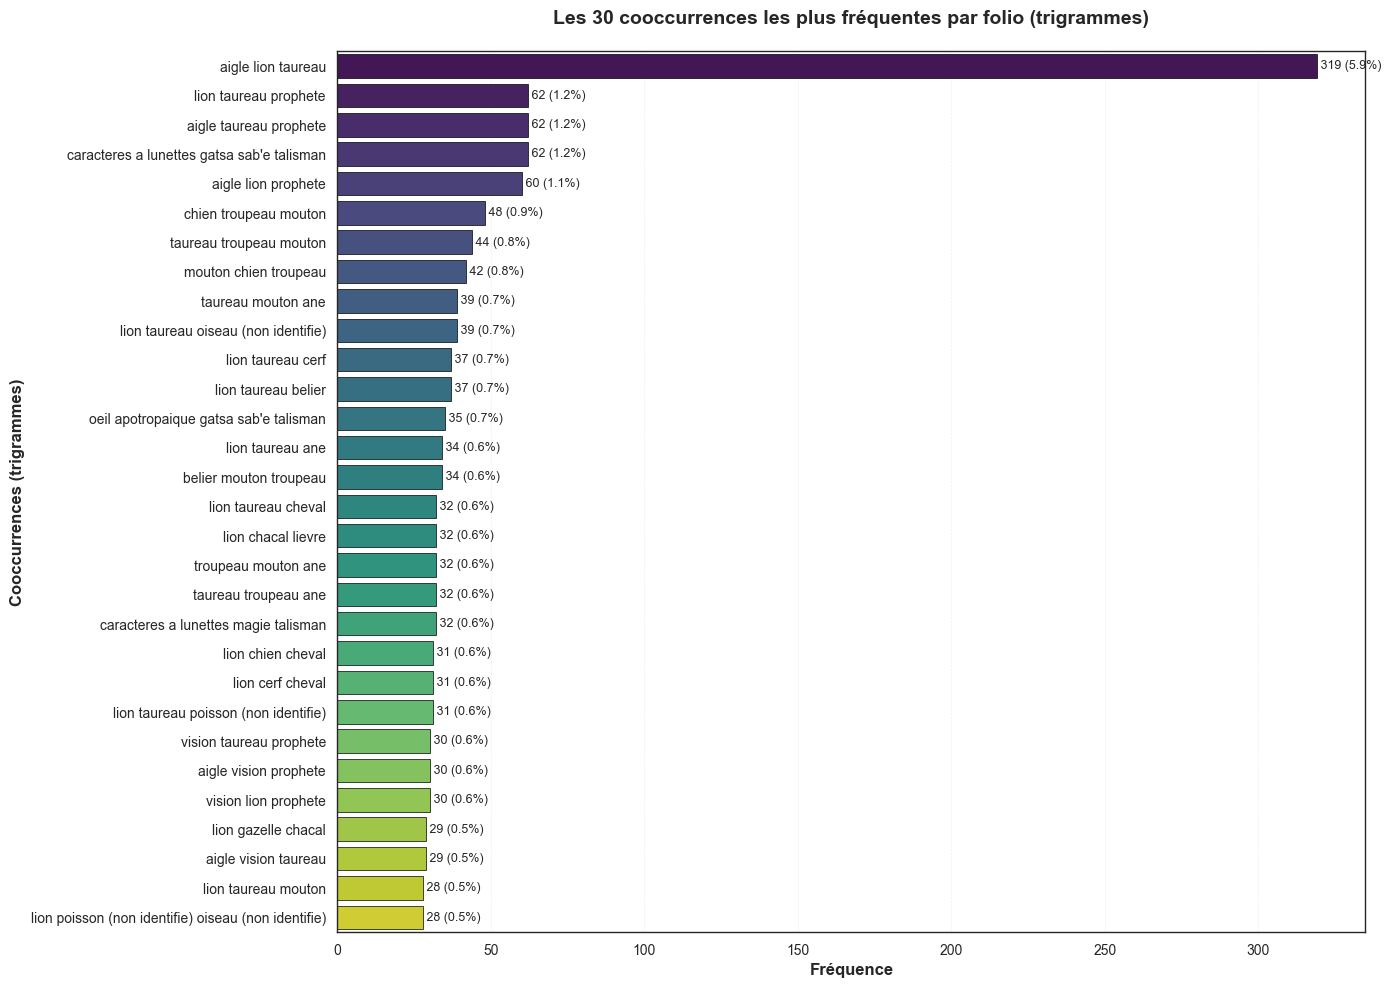

/var/folders/4m/_y65_yfx68b53909_pvhthr40000gn/T/ipykernel_6633/4043419706.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


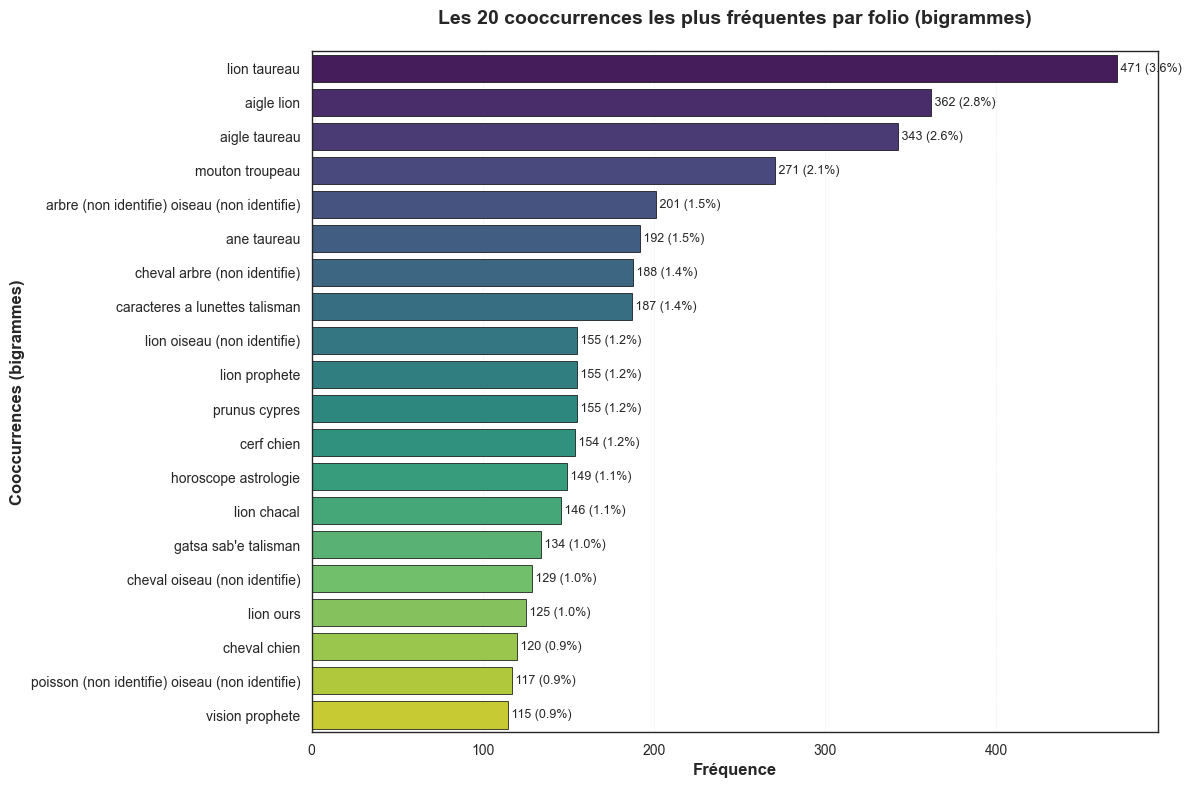

/var/folders/4m/_y65_yfx68b53909_pvhthr40000gn/T/ipykernel_6633/4043419706.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


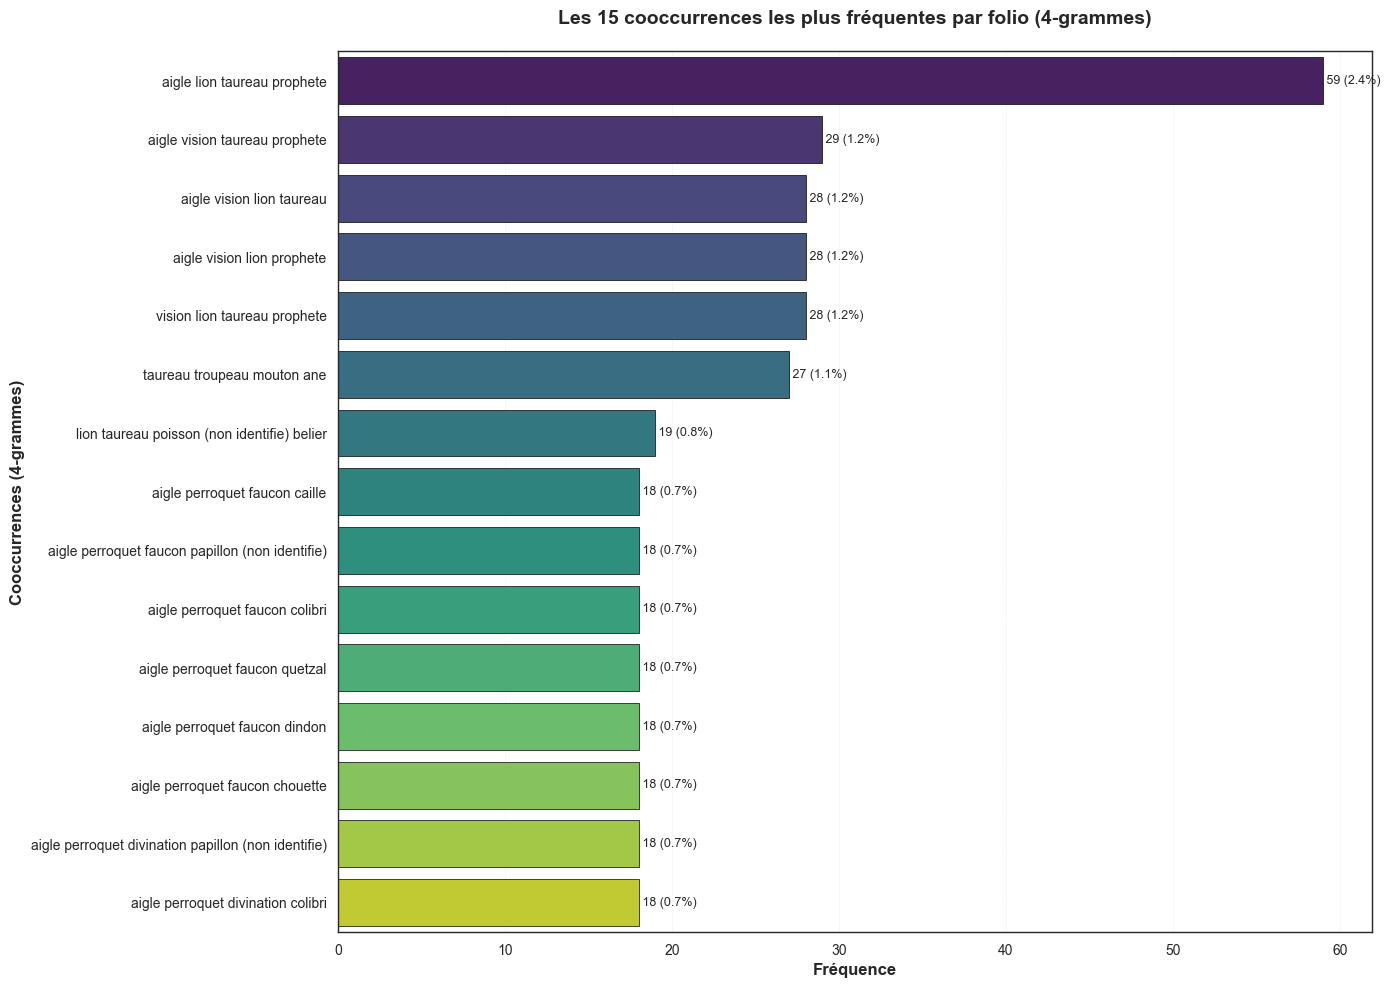

(<Figure size 1400x1000 with 1 Axes>,
 <Axes: title={'center': 'Les 15 cooccurrences les plus fréquentes par folio (4-grammes)'}, xlabel='Fréquence', ylabel='Cooccurrences (4-grammes)'>)

In [ ]:
def plot_most_common(df, n_top, ngram_size=3, figsize=(12, 8), save_path=None, dpi=300):
    """
    Visualise les n cooccurrences les plus fréquentes par folio.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame contenant les données
    n_top : int
        Nombre de cooccurrences à afficher
    ngram_size : int
        Taille des n-grams à analyser (2 pour bigrams, 3 pour trigrams, etc.)
    figsize : tuple
        Dimensions de la figure (largeur, hauteur)
    save_path : str, optional
        Chemin pour sauvegarder la figure
    dpi : int
        Résolution pour la sauvegarde
    """
    # Vérification que la colonne existe
    ngram_col = f"ngrams_{ngram_size}"
    if ngram_col not in df.columns:
        raise ValueError(f"La colonne '{ngram_col}' n'existe pas dans le DataFrame. "
                        f"Colonnes disponibles: {df.columns.tolist()}")
    
    # Extraction des données
    liste_ngram = df[ngram_col].dropna()
    top = Counter(liste_ngram.explode().to_list()).most_common(n_top)
    labels = [i[0].strip() for i in top]
    counts = [i[1] for i in top]
    
    # Création de la figure
    fig, ax = plt.subplots(figsize=figsize)
    
    
    palette = sns.color_palette('viridis', n_colors=n_top)
    
    
    # Création du barplot
    sns.barplot(
        y=labels, 
        x=counts, 
        palette=palette,
        
        ax=ax,
        edgecolor='black',
        linewidth=0.5
    )
    
    # Amélioration du nom des n-grams
    ngram_names = {2: 'bigrammes', 3: 'trigrammes', 4: '4-grammes', 5: '5-grammes'}
    ngram_label = ngram_names.get(ngram_size, f'{ngram_size}-grammes')
    
    
    ax.set_title(
        f'Les {n_top} cooccurrences les plus fréquentes par folio ({ngram_label})',
        fontsize=14,
        fontweight='bold',
        pad=20
    )
    ax.set_xlabel('Fréquence', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Cooccurrences ({ngram_label})', fontsize=12, fontweight='bold')
    
    # Ajout des valeurs sur les barres avec pourcentages (pas sûr pour les pourcentages)
    total = len(liste_ngram)
    for i, count in enumerate(counts):
        pct = count / total * 100
        ax.text(
            count, i, 
            f' {count} ({pct:.1f}%)', 
            va='center', 
            ha='left', 
            fontsize=9
        )
    
    ax.tick_params(axis='both', labelsize=10)
    plt.tight_layout()

    
    ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Sauvegarde 
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', 
                    facecolor='white', edgecolor='none')
    
    plt.show()
    
    return fig, ax


plot_most_common(df, n_top=30, ngram_size=3, figsize=(14, 10), 
                 save_path='cooccurrences_top30_trigrams.png')


plot_most_common(df, n_top=20, ngram_size=2, figsize=(12, 8), 
                 save_path='cooccurrences_top20_bigrams.png')


plot_most_common(df, n_top=15, ngram_size=4, figsize=(14, 10))

In [ ]:
df.caption = df.caption.apply(lambda x : 'Talisman' if 'talisman' in str(x).lower() else x)
df.caption = df.caption.apply(lambda x : 'Astronomie/Astrologie' if 'astro' in str(x).lower() else x)
df.caption = df.caption.apply(lambda x : 'Fable(s)' if 'fable' in str(x).lower() else x)
to_erase = ["encadrement", "lettre ornée", "décor marginal", "lettre filigranée", "bout-de-ligne" , "bandeau"]
liste_keep = [i for i in df.caption.tolist() if str(i).lower() not in to_erase]
df_new = df[df.caption.isin(liste_keep)]

In [ ]:
df_top5= df_new[df_new.caption.isin(['Bible', "Talisman", "Fable(s)",'Astronomie/Astrologie','Égypte'])]

In [ ]:
###
import pandas as pd 
import ast
df_all = pd.read_csv('data_ngrams_propre.csv')
df_all.kw = df_all.kw.apply(ast.literal_eval)

In [ ]:
## test sp and ble
df_all['sp'] = df_all.kw.apply(lambda x :'saint-pierre' in x)



In [ ]:
from collections import Counter
Counter(df_all[df_all.sp == True].caption.to_list()).most_common(10)


In [ ]:
def cleaning(kw):
    black_list = {'saint-pierre', "bernard-l'ermite"}
    return [x for x in kw if x not in black_list]

In [ ]:
df.kw = df.kw.apply(cleaning)

In [ ]:
df = pd.read_csv('data_ngrams_propre.csv')

In [ ]:
df.caption = df.caption.apply(lambda x : 'Talisman' if 'talisman' in str(x).lower() else x)
df.caption = df.caption.apply(lambda x : 'Astronomie_Astrologie' if 'astro' in str(x).lower() else x)
df.caption = df.caption.apply(lambda x : 'Fable(s)' if 'fable' in str(x).lower() else x)
to_erase = ["encadrement", "lettre ornée", "décor marginal", "lettre filigranée", "bout-de-ligne" , "bandeau"]
liste_keep = [i for i in df.caption.tolist() if str(i).lower() not in to_erase]
df_new = df[df.caption.isin(liste_keep)]

In [ ]:
import ast
df_new.kw =df.kw.apply(ast.literal_eval)

In [ ]:
df_new.kw = df_new.kw.apply(cleaning)

In [ ]:
## cooc
from itertools import combinations
def ngrams_combinations(seq, n):
    return [" ".join(c) for c in combinations(seq, n)] if len(seq) >= n else None

# ============================================================
# 4) Ajouter colonne n-grams (bigrams + trigrams)
# ============================================================
for i in range(1,6) : 
    df_new[f"ngrams_{i}"] = df_new["kw"].apply(lambda seq: ngrams_combinations(seq, i))

In [ ]:
to_keep = ['Bible', "Talisman", "Fable(s)",'Astronomie_Astrologie','Égypte']
for i in to_keep : 
    df_new[df_new.caption == i ].to_csv(f'{i}.csv')

In [ ]:
#df_new.kw = df_new.kw.apply(lambda x : x if len(x)>=1 else None)
df_dropped = df_new.dropna(subset=['kw'])

In [ ]:
Counter(df_dropped.caption).most_common(10)

In [ ]:
df_new

In [ ]:
###
from collections import defaultdict
#df_new.kw = df_new.kw.apply(cleaning)
to_keep = ['Bible', "Talisman", "Fable(s)",'Astronomie_Astrologie','Égypte']
for i in to_keep:
    def group_unordered_trigrams(lst):
        groups = defaultdict(list)
        for s in lst:
            tokens = s.split()
            key = " ".join(sorted(tokens))     # clé plus pratique : string triée
            groups[key].append(s)
        return groups

    # Regroupe les trigrammes
    result = group_unordered_trigrams(
        df_new[df_new.caption == i ].ngrams_3.explode().dropna().tolist()
    )

    flat_list = [
        key
        for key, values in result.items()
        for _ in values
    ]

    def plot_most_common(values, n):
        top = Counter(values).most_common(n)
        palette = sns.color_palette('autumn')
        sns.barplot(
            y=[i[0] for i in top],
            x=[i[1] for i in top],
            palette=palette
        )
        plt.title(f'{n} 3-grammes (triés) les plus fréquents dans le corpus: {i}')

    plot_most_common(flat_list, 10)
    plt.show()
    plt.savefig(f'{10} 3-grammes (triés) les plus fréquents dans le corpus: {i}.png'.replace(' ','_'))

In [ ]:
df_no =pd.read_csv('/Users/rolly/Documents/10-19_Université_et_scolarité/hackathon_pictoria/mandragore_nh_global.csv',sep= ';')

In [ ]:
t = Counter(df_no.caption).most_common(30)

In [ ]:
plt.figure(figsize=(16,9))
sns.barplot(y=[i[0] for i in t], x= [i[1] for i in t], palette=sns.color_palette('autumn'))
plt.title('30 captions les plus représentées')

In [ ]:
df=df_no.copy()
df.caption = df.caption.apply(lambda x : 'Talisman' if 'talisman' in str(x).lower() else x)
df.caption = df.caption.apply(lambda x : 'Astronomie_Astrologie' if 'astro' in str(x).lower() else x)
df.caption = df.caption.apply(lambda x : 'Fable(s)' if 'fable' in str(x).lower() else x)
to_erase = ["encadrement", "lettre ornée", "décor marginal", "lettre filigranée", "bout-de-ligne" , "bandeau"]
liste_keep = [i for i in df.caption.tolist() if str(i).lower() not in to_erase]
df_new = df[df.caption.isin(liste_keep)]

In [ ]:
t = Counter(df_new.caption).most_common(20)
plt.figure(figsize=(16,9))
sns.barplot(y=[i[0] for i in t], x= [i[1] for i in t], palette=sns.color_palette('autumn'))
plt.title('20 captions les plus représentées (après nettoyage et fusion)')

In [ ]:
df_new.sort_values(by = 'nbkw', ascending=False)